# 1. Pregled in izbor podatkov

V tem koraku pregledamo dostopne podatke na javno dostopnih podatkovnih bazah. Podatki dostopni na ChEMBL in BindingDB vsebujejo podatke o molekulah testiranih na človeških in mišjih IDO1, IDO2 ter TDO encimih. Da bi dobili čimvečji a hkrati reprezentativen vzorec podatkov v tem koraku pregledamo vse podatke in se odločimo za nadaljno selekcijo

V koraku Pregled podatkov pregeledamo podatke dostopne na javno dostopnih podatkovnih bazah ChEMBL in BindingDB

# Uvoz knjižnic in splošnih funkcij

In [1]:
%run __A_knjiznice.py
from __A_knjiznice import *

%matplotlib inline

/Users/samonose/PycharmProjects/IDO_inhibitors_ML_predictions/dir1
/Users/samonose/PycharmProjects/IDO_inhibitors_ML_predictions/dir1


# Pridobitev podatkov

# Pridobitev podatkov z BindingDb

In [2]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# Mapping of Uniprot IDs to organisms
uniprot_organism_map = {
    'P14902': 'Homo sapiens',
    'Q6ZQW0': 'Homo sapiens',
    'P48775': 'Homo sapiens',
    'P28776': 'Mus musculus',
    'Q8R0V5': 'Mus musculus',
    'P48776': 'Mus musculus' 
}

# Function to get enzyme name from UniProt
def fetch_enzyme_name(uniprot_id):
    uniprot_url = f'https://www.uniprot.org/uniprot/{uniprot_id}.xml'
    response = requests.get(uniprot_url)
    if response.status_code == 200:
        root = ET.fromstring(response.content)
        for protein in root.iter('{http://uniprot.org/uniprot}protein'):
            enzyme_name = protein.find('{http://uniprot.org/uniprot}recommendedName').find('{http://uniprot.org/uniprot}fullName').text
            return enzyme_name
    return None

# URLs for BindingDB queries
URL = [
    'https://bindingdb.org/axis2/services/BDBService/getLigandsByUniprot?uniprot=P14902;1000000',
    'https://bindingdb.org/axis2/services/BDBService/getLigandsByUniprot?uniprot=Q6ZQW0;1000000',
    'https://bindingdb.org/axis2/services/BDBService/getLigandsByUniprot?uniprot=P48775;1000000',
    'https://bindingdb.org/axis2/services/BDBService/getLigandsByUniprot?uniprot=P28776;1000000',
    'https://bindingdb.org/axis2/services/BDBService/getLigandsByUniprot?uniprot=Q8R0V5;1000000',
    'https://bindingdb.org/axis2/services/BDBService/getLigandsByUniprot?uniprot=P48776;1000000',
]

data = []

for url in URL:
    uniprot_id = url.split('?uniprot=')[1].split(';')[0]  # Extract Uniprot ID from the URL
    target_organism = uniprot_organism_map.get(uniprot_id, 'Unknown')  # Look up organism
    enzyme_name = fetch_enzyme_name(uniprot_id)  # Get enzyme name from UniProt

    response = requests.get(url)
    if response.status_code == 200:
        print(f"Request {url} ok: {response.status_code}")
        xml_string = response.content
        root = ET.fromstring(xml_string)
        
        for aff in root.iter('{http://ws.bindingdb.org/xsd}affinities'):
            monomer_id = aff.find('{http://ws.bindingdb.org/xsd}monomerid').text
            smiles = aff.find('{http://ws.bindingdb.org/xsd}smiles').text
            affinity_type = aff.find('{http://ws.bindingdb.org/xsd}affinity_type').text
            affinity = aff.find('{http://ws.bindingdb.org/xsd}affinity').text
            
            # Add target_organism and enzyme_name to the data list
            data.append([monomer_id, smiles, affinity_type, affinity, target_organism, enzyme_name])
    else:
        print(f"Request to {url} failed with status code: {response.status_code}")

# Create DataFrame with target_organism and enzyme_name columns
df = pd.DataFrame(data, columns=['monomer_id', 'smiles', 'affinity_type', 'affinity', 'target_organism', 'enzyme_name'])
binding_db_molecules = df

binding_db_molecules

Request https://bindingdb.org/axis2/services/BDBService/getLigandsByUniprot?uniprot=P14902;1000000 ok: 200
Request https://bindingdb.org/axis2/services/BDBService/getLigandsByUniprot?uniprot=Q6ZQW0;1000000 ok: 200
Request https://bindingdb.org/axis2/services/BDBService/getLigandsByUniprot?uniprot=P48775;1000000 ok: 200
Request https://bindingdb.org/axis2/services/BDBService/getLigandsByUniprot?uniprot=P28776;1000000 ok: 200
Request https://bindingdb.org/axis2/services/BDBService/getLigandsByUniprot?uniprot=Q8R0V5;1000000 ok: 200
Request https://bindingdb.org/axis2/services/BDBService/getLigandsByUniprot?uniprot=P48776;1000000 ok: 200


,monomer_id,smiles,affinity_type,affinity,target_organism,enzyme_name
0,17448,c1[nH]nnc1-c1ccccc1,IC50,8900,Homo sapiens,"Indoleamine 2,3-dioxygenase 1"
1,17448,c1[nH]nnc1-c1ccccc1,Ki,22500,Homo sapiens,"Indoleamine 2,3-dioxygenase 1"
2,17452,Cc1ccccc1-c1c[nH]nn1,IC50,39000,Homo sapiens,"Indoleamine 2,3-dioxygenase 1"
3,17453,COc1ccccc1-c1c[nH]nn1,IC50,>100000,Homo sapiens,"Indoleamine 2,3-dioxygenase 1"
4,17459,Clc1ccc(cc1)-c1c[nH]nn1,IC50,530000,Homo sapiens,"Indoleamine 2,3-dioxygenase 1"
...,...,...,...,...,...,...
6136,50391375,[O-][N+](=O)c1cccc(c1)-c1c[nH]nn1,IC50,>100000,Mus musculus,"Tryptophan 2,3-dioxygenase"
6137,50391376,FC(F)(F)c1ccccc1-c1c[nH]nn1,IC50,>100000,Mus musculus,"Tryptophan 2,3-dioxygenase"
6138,50514752,O=C(NCc1cccc(Cn2cnc3ccccc23)c1)c1ccc(cc1)C#N,IC50,32300,Mus musculus,"Tryptophan 2,3-dioxygenase"
6139,50514753,Brc1c[nH]c(c1)C(=O)NCc1cccc(Cn2cnc3ccccc23)c1,IC50,5460,Mus musculus,"Tryptophan 2,3-dioxygenase"


In [3]:
binding_db_molecules

,monomer_id,smiles,affinity_type,affinity,target_organism,enzyme_name
0,17448,c1[nH]nnc1-c1ccccc1,IC50,8900,Homo sapiens,"Indoleamine 2,3-dioxygenase 1"
1,17448,c1[nH]nnc1-c1ccccc1,Ki,22500,Homo sapiens,"Indoleamine 2,3-dioxygenase 1"
2,17452,Cc1ccccc1-c1c[nH]nn1,IC50,39000,Homo sapiens,"Indoleamine 2,3-dioxygenase 1"
3,17453,COc1ccccc1-c1c[nH]nn1,IC50,>100000,Homo sapiens,"Indoleamine 2,3-dioxygenase 1"
4,17459,Clc1ccc(cc1)-c1c[nH]nn1,IC50,530000,Homo sapiens,"Indoleamine 2,3-dioxygenase 1"
...,...,...,...,...,...,...
6136,50391375,[O-][N+](=O)c1cccc(c1)-c1c[nH]nn1,IC50,>100000,Mus musculus,"Tryptophan 2,3-dioxygenase"
6137,50391376,FC(F)(F)c1ccccc1-c1c[nH]nn1,IC50,>100000,Mus musculus,"Tryptophan 2,3-dioxygenase"
6138,50514752,O=C(NCc1cccc(Cn2cnc3ccccc23)c1)c1ccc(cc1)C#N,IC50,32300,Mus musculus,"Tryptophan 2,3-dioxygenase"
6139,50514753,Brc1c[nH]c(c1)C(=O)NCc1cccc(Cn2cnc3ccccc23)c1,IC50,5460,Mus musculus,"Tryptophan 2,3-dioxygenase"


In [4]:
filename = 'binding_db_molecules.csv'
dir_path = os.path.join(PATH, filename)
binding_db_molecules.to_csv(dir_path,index=False)

In [5]:
# odstranim NA vrednosti

binding_db_molecules.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {binding_db_molecules.shape}")

DataFrame shape: (6141, 6)


In [6]:
# podatkovni okvir filtriram tako da spremljamo le IC50 vrednosti

binding_db_molecules = binding_db_molecules[binding_db_molecules['affinity_type'] == 'IC50']
binding_db_molecules.shape

(5534, 6)

In [7]:
# afiniteto preimenujem v IC50, odstranim tudi ne-enacaje

warnings.filterwarnings("ignore")

binding_db_molecules['affinity'] = binding_db_molecules['affinity'].str.replace('[><]', '', regex=True)

binding_db_molecules = binding_db_molecules.astype({"affinity": "float64"})

binding_db_molecules.drop(columns=['affinity_type'],  inplace=True)

binding_db_molecules.rename(
    columns={"affinity": "IC50"}, inplace=True
)
#binding_db_molecules.head()

In [8]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [9]:
# Apply conversion to each row of the compounds DataFrame
binding_db_molecules["pIC50"] = binding_db_molecules.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)
binding_db_molecules

,monomer_id,smiles,IC50,target_organism,enzyme_name,pIC50
0,17448,c1[nH]nnc1-c1ccccc1,8900.0,Homo sapiens,"Indoleamine 2,3-dioxygenase 1",5.050610
2,17452,Cc1ccccc1-c1c[nH]nn1,39000.0,Homo sapiens,"Indoleamine 2,3-dioxygenase 1",4.408935
3,17453,COc1ccccc1-c1c[nH]nn1,100000.0,Homo sapiens,"Indoleamine 2,3-dioxygenase 1",4.000000
4,17459,Clc1ccc(cc1)-c1c[nH]nn1,530000.0,Homo sapiens,"Indoleamine 2,3-dioxygenase 1",3.275724
5,17462,Cc1cccc(c1)-c1c[nH]nn1,7000.0,Homo sapiens,"Indoleamine 2,3-dioxygenase 1",5.154902
...,...,...,...,...,...,...
6136,50391375,[O-][N+](=O)c1cccc(c1)-c1c[nH]nn1,100000.0,Mus musculus,"Tryptophan 2,3-dioxygenase",4.000000
6137,50391376,FC(F)(F)c1ccccc1-c1c[nH]nn1,100000.0,Mus musculus,"Tryptophan 2,3-dioxygenase",4.000000
6138,50514752,O=C(NCc1cccc(Cn2cnc3ccccc23)c1)c1ccc(cc1)C#N,32300.0,Mus musculus,"Tryptophan 2,3-dioxygenase",4.490797
6139,50514753,Brc1c[nH]c(c1)C(=O)NCc1cccc(Cn2cnc3ccccc23)c1,5460.0,Mus musculus,"Tryptophan 2,3-dioxygenase",5.262807


In [10]:
# Assuming your DataFrame is named 'bioactivities_df'

# Count the unique values in 'monomer_id' column
unique_monomer_ids = binding_db_molecules['monomer_id'].nunique()

# Count the unique values in 'SMILES' column
unique_smiles = binding_db_molecules['smiles'].nunique()

# Print the results
print(f"Number of unique monomer_ids: {unique_monomer_ids}")
print(f"Number of unique SMILES: {unique_smiles}")


Number of unique monomer_ids: 4447
Number of unique SMILES: 4447


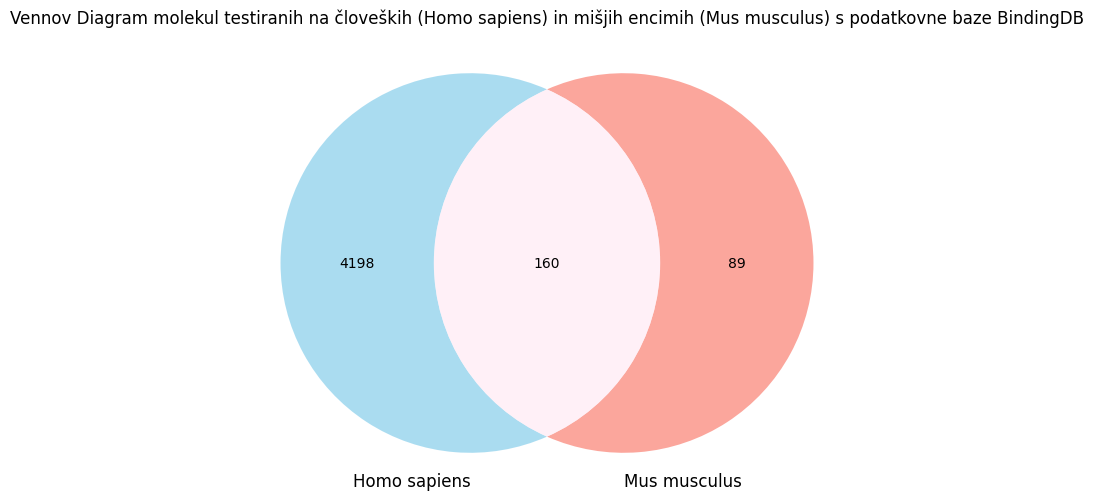

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2_unweighted



# Calculate sets for Human and Mouse based on the 'target_organism' and 'monomer_id'
human_set = set(binding_db_molecules[binding_db_molecules['target_organism'] == 'Homo sapiens']['monomer_id'])
mouse_set = set(binding_db_molecules[binding_db_molecules['target_organism'] == 'Mus musculus']['monomer_id'])

# Calculate only human, only mouse, and both (intersection)
only_human = len(human_set - mouse_set)
only_mouse = len(mouse_set - human_set)
both = len(human_set & mouse_set)

# Plot the Venn diagram using venn2_unweighted
plt.figure(figsize=(8, 6))
venn2_unweighted(
    subsets=(only_human, only_mouse, both), 
    set_labels=('Homo sapiens', 'Mus musculus'),
    set_colors=("skyblue", "salmon"), alpha=0.7
)

# Set a title for the plot
plt.title('Vennov Diagram molekul testiranih na človeških (Homo sapiens) in mišjih encimih (Mus musculus) s podatkovne baze BindingDB')

# Show the plot
plt.show()

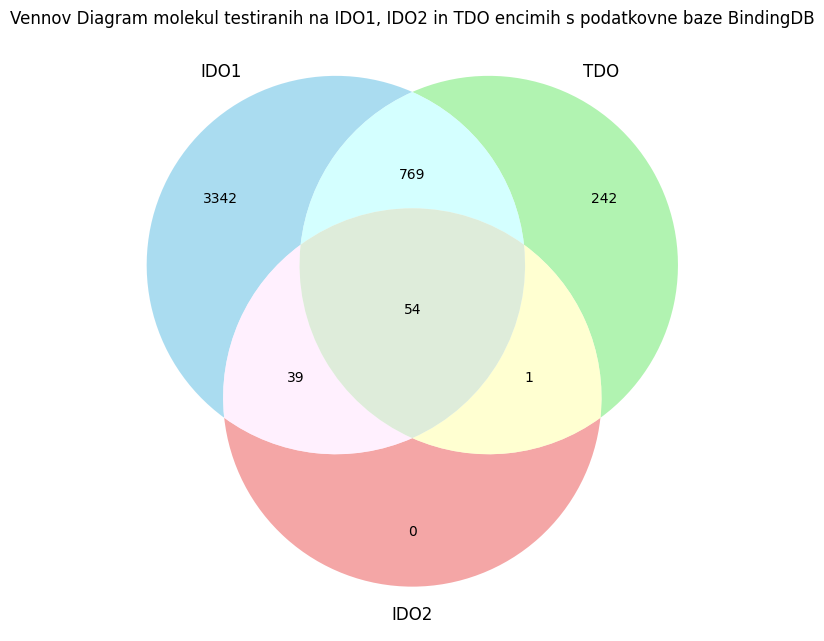

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted

# Assuming your DataFrame is already loaded, and it contains 'enzyme_name', 'target_organism', and 'monomer_id' columns.
# Example: binding_db_molecules = pd.read_csv('your_data.csv')

# Enzyme names we're interested in
enzyme_names = ['Indoleamine 2,3-dioxygenase 1', 'Tryptophan 2,3-dioxygenase', 'Indoleamine 2,3-dioxygenase 2']

# Get sets of monomer_ids associated with each enzyme name
enzyme_set1 = set(binding_db_molecules[binding_db_molecules['enzyme_name'] == enzyme_names[0]]['monomer_id'])
enzyme_set2 = set(binding_db_molecules[binding_db_molecules['enzyme_name'] == enzyme_names[1]]['monomer_id'])
enzyme_set3 = set(binding_db_molecules[binding_db_molecules['enzyme_name'] == enzyme_names[2]]['monomer_id'])

# Create the Venn diagram for monomer_id distributions over enzymes
plt.figure(figsize=(8, 8))
venn = venn3_unweighted(
    subsets=(enzyme_set1, enzyme_set2, enzyme_set3),  # Monomer ID sets based on enzyme names
    set_labels=("IDO1", "TDO", "IDO2"),  # Enzyme names as labels
    set_colors=("skyblue", "lightgreen", "lightcoral"), alpha=0.7
)

# Set the title
plt.title("Vennov Diagram molekul testiranih na IDO1, IDO2 in TDO encimih s podatkovne baze BindingDB")

# Show the plot
plt.show()

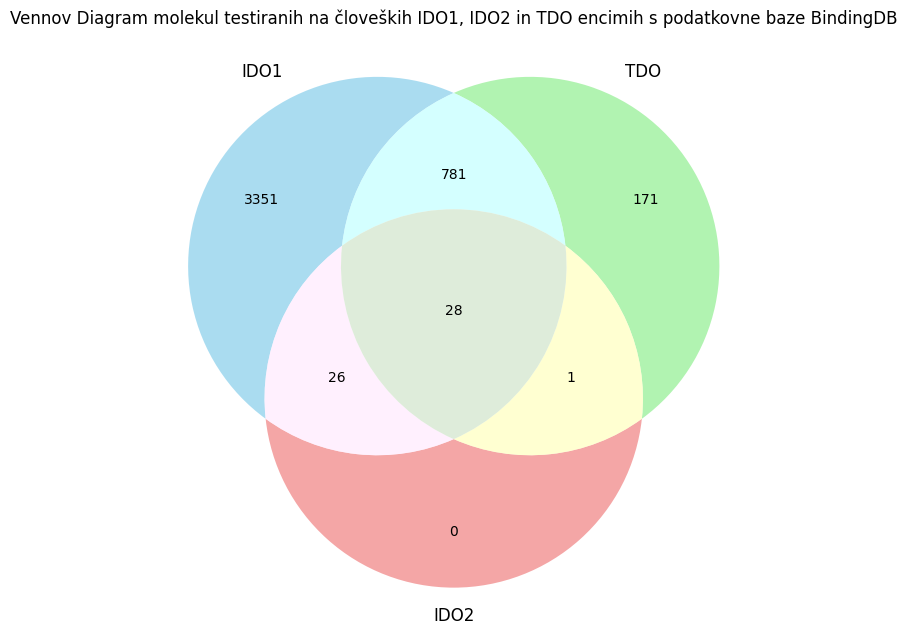

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted

# Assuming your DataFrame is already loaded with 'enzyme_name', 'target_organism', and 'monomer_id' columns.
# Filter for Homo sapiens molecules only
human_molecules = binding_db_molecules[binding_db_molecules['target_organism'] == 'Homo sapiens']

# Enzyme names of interest
enzyme_names = ['Indoleamine 2,3-dioxygenase 1', 'Tryptophan 2,3-dioxygenase', 'Indoleamine 2,3-dioxygenase 2']

# Get sets of monomer_ids associated with each enzyme name
enzyme_set1 = set(human_molecules[human_molecules['enzyme_name'] == enzyme_names[0]]['monomer_id'])
enzyme_set2 = set(human_molecules[human_molecules['enzyme_name'] == enzyme_names[1]]['monomer_id'])
enzyme_set3 = set(human_molecules[human_molecules['enzyme_name'] == enzyme_names[2]]['monomer_id'])

# Create the Venn diagram for monomer_id distributions over enzymes
plt.figure(figsize=(8, 8))
venn3_unweighted(
    subsets=(enzyme_set1, enzyme_set2, enzyme_set3),
    set_labels=("IDO1", "TDO", "IDO2"),
    set_colors=("skyblue", "lightgreen", "lightcoral"),
    alpha=0.7
)

# Set the title
plt.title("Vennov Diagram molekul testiranih na človeških IDO1, IDO2 in TDO encimih s podatkovne baze BindingDB")

# Show the plot
plt.show()


# Pridobitev podatkov z chEMBL

In [14]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

type(targets_api)


uniprot_id = ["P14902", "Q6ZQW0","P48775", "P28776", "Q8R0V5", "P48776"]


# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

targets = pd.DataFrame.from_records(targets)
targets.drop_duplicates(inplace=True)
targets

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,"Tryptophan 2,3-dioxygenase",CHEMBL2140,SINGLE PROTEIN
2,Homo sapiens,"Indoleamine 2,3-dioxygenase",CHEMBL4685,SINGLE PROTEIN
3,Mus musculus,"Indoleamine 2,3-dioxygenase 1",CHEMBL1075294,SINGLE PROTEIN
4,Mus musculus,"Tryptophan 2,3-dioxygenase",CHEMBL1075307,SINGLE PROTEIN
5,Mus musculus,"Indoleamine 2,3-dioxygenase 2",CHEMBL2189159,SINGLE PROTEIN
6,Homo sapiens,"Indoleamine 2,3-dioxygenase 2",CHEMBL3627587,SINGLE PROTEIN
7,Homo sapiens,"Cereblon/Indoleamine 2,3-dioxygenase 1",CHEMBL4742272,PROTEIN-PROTEIN INTERACTION
8,Homo sapiens,IDO1/VHL,CHEMBL5169061,PROTEIN-PROTEIN INTERACTION
9,Mus musculus,Ido1/Crbn,CHEMBL5169091,PROTEIN-PROTEIN INTERACTION


In [15]:
targets_df = targets[targets['target_type'] == 'SINGLE PROTEIN']
targets_df
# IDO1 CHEMBL4685 , CHEMBL1075294
# IDO2 CHEMBL2189159 , CHEMBL3627587
# TDO CHEMBL2140 , CHEMBL1075307

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,"Tryptophan 2,3-dioxygenase",CHEMBL2140,SINGLE PROTEIN
2,Homo sapiens,"Indoleamine 2,3-dioxygenase",CHEMBL4685,SINGLE PROTEIN
3,Mus musculus,"Indoleamine 2,3-dioxygenase 1",CHEMBL1075294,SINGLE PROTEIN
4,Mus musculus,"Tryptophan 2,3-dioxygenase",CHEMBL1075307,SINGLE PROTEIN
5,Mus musculus,"Indoleamine 2,3-dioxygenase 2",CHEMBL2189159,SINGLE PROTEIN
6,Homo sapiens,"Indoleamine 2,3-dioxygenase 2",CHEMBL3627587,SINGLE PROTEIN


In [16]:
target = targets_df
chembl_id = target['target_chembl_id']
chembl_id_list = chembl_id.to_list()
chembl_id_list

['CHEMBL2140',
 'CHEMBL4685',
 'CHEMBL1075294',
 'CHEMBL1075307',
 'CHEMBL2189159',
 'CHEMBL3627587']

In [17]:
bioactivities = bioactivities_api.filter(
    target_chembl_id__in = chembl_id_list, type="IC50", relation="=", assay_type="B"
).only(
        "activity_id",
        "assay_chembl_id",
        "assay_description",
        "assay_type",
        "molecule_chembl_id",
        "type",
        "standard_units",
        "relation",
        "standard_value",
        "target_chembl_id",
        "target_organism",
    )

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 4327, <class 'chembl_webresource_client.query_set.QuerySet'>


In [18]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
#bioactivities[0]

Length and type of first element: 13, <class 'dict'>


In [19]:
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
#bioactivities_df.head()

DataFrame shape: (4327, 13)


In [20]:
filename = 'chembl_molecules.csv'
dir_path = os.path.join(PATH, filename)
bioactivities_df.to_csv(dir_path,index=False)

In [21]:
bioactivities_df["units"].unique()

array(['uM', 'nM', 'mM', "10'-2M", "10'-5M", 'ug ml-1'], dtype=object)

In [22]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,2120165,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL318782,=,nM,280.0,CHEMBL4685,Homo sapiens,IC50
1,2120166,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL271826,=,nM,1500.0,CHEMBL4685,Homo sapiens,IC50
2,2120167,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL272225,=,nM,512.0,CHEMBL4685,Homo sapiens,IC50
3,2120168,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL441441,=,nM,4340.0,CHEMBL4685,Homo sapiens,IC50
4,2120169,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL258816,=,nM,2120.0,CHEMBL4685,Homo sapiens,IC50


In [23]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
# bioactivities_df.dtypes

In [24]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (4327, 11)


In [25]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (4327, 11)


In [26]:
bioactivities_df

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,2120165,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL318782,=,nM,280.0,CHEMBL4685,Homo sapiens,IC50
1,2120166,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL271826,=,nM,1500.0,CHEMBL4685,Homo sapiens,IC50
2,2120167,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL272225,=,nM,512.0,CHEMBL4685,Homo sapiens,IC50
3,2120168,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL441441,=,nM,4340.0,CHEMBL4685,Homo sapiens,IC50
4,2120169,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL258816,=,nM,2120.0,CHEMBL4685,Homo sapiens,IC50
...,...,...,...,...,...,...,...,...,...,...,...
4322,25093858,CHEMBL5259436,Inhibition of IDO1 (unknown origin) expressed ...,B,CHEMBL5273615,=,nM,1.5,CHEMBL4685,Homo sapiens,IC50
4323,25093859,CHEMBL5259436,Inhibition of IDO1 (unknown origin) expressed ...,B,CHEMBL5273615,=,nM,4.6,CHEMBL4685,Homo sapiens,IC50
4324,25093860,CHEMBL5259436,Inhibition of IDO1 (unknown origin) expressed ...,B,CHEMBL5267407,=,nM,3.6,CHEMBL4685,Homo sapiens,IC50
4325,25093861,CHEMBL5259436,Inhibition of IDO1 (unknown origin) expressed ...,B,CHEMBL5267407,=,nM,15.0,CHEMBL4685,Homo sapiens,IC50


In [27]:
bioactivities_df["standard_units"].unique()

array(['nM', 'ug.mL-1'], dtype=object)

In [28]:
bioactivities_df["relation"].unique()

array(['='], dtype=object)

In [29]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [30]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [31]:
bioactivities_df.reset_index(drop=True, inplace=True)
#bioactivities_df.head()

In [32]:
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,2120165,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL318782,=,nM,280.0,CHEMBL4685,Homo sapiens,IC50
1,2120166,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL271826,=,nM,1500.0,CHEMBL4685,Homo sapiens,IC50
2,2120167,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL272225,=,nM,512.0,CHEMBL4685,Homo sapiens,IC50
3,2120168,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL441441,=,nM,4340.0,CHEMBL4685,Homo sapiens,IC50
4,2120169,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL258816,=,nM,2120.0,CHEMBL4685,Homo sapiens,IC50


In [33]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (4326, 11)


In [34]:
# Assuming your DataFrame is named 'bioactivities_df' and has 'target_organism' and 'molecule_chembl_id'

# Group by target organism and count unique molecule_chembl_id
organism_counts = bioactivities_df.groupby('target_organism')['molecule_chembl_id'].nunique()
molecules_count = bioactivities_df['molecule_chembl_id'].nunique()
# Print the counts of unique molecules per target organism
print("# molekul glede na organizem:")
print(organism_counts)
print(f" \n# unikatnih molekul v celotnem vzorcu {molecules_count}")

# molekul glede na organizem:
target_organism
Homo sapiens    2375
Mus musculus     195
Name: molecule_chembl_id, dtype: int64
 
# unikatnih molekul v celotnem vzorcu 2417


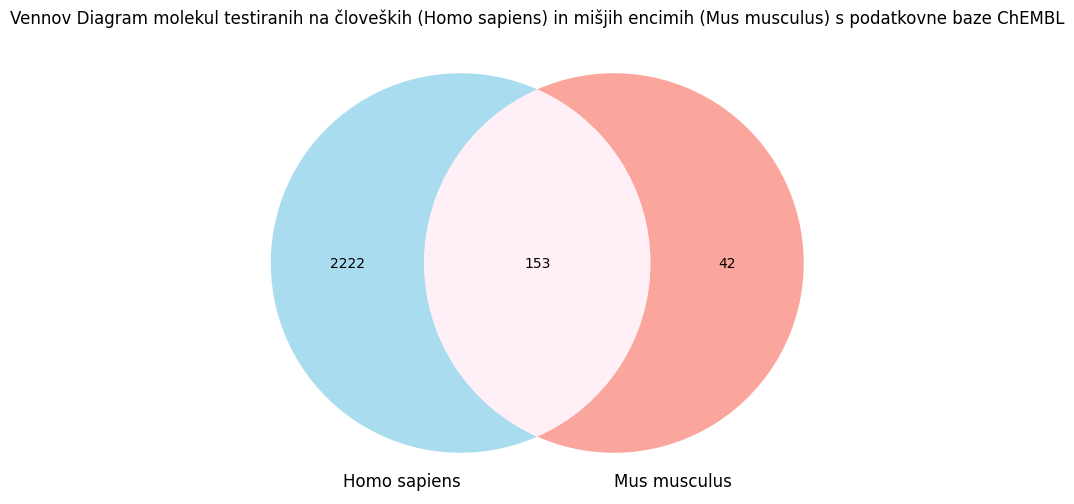

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2_unweighted



# Calculate sets for Human and Mouse based on the 'target_organism' and 'monomer_id'
human_set = set(bioactivities_df[bioactivities_df['target_organism'] == 'Homo sapiens']['molecule_chembl_id'])
mouse_set = set(bioactivities_df[bioactivities_df['target_organism'] == 'Mus musculus']['molecule_chembl_id'])

# Calculate only human, only mouse, and both (intersection)
only_human = len(human_set - mouse_set)
only_mouse = len(mouse_set - human_set)
both = len(human_set & mouse_set)

# Plot the Venn diagram using venn2_unweighted
plt.figure(figsize=(8, 6))
venn2_unweighted(
    subsets=(only_human, only_mouse, both), 
    set_labels=('Homo sapiens', 'Mus musculus'),
    set_colors=("skyblue", "salmon"), alpha=0.7
)

# Set a title for the plot
plt.title('Vennov Diagram molekul testiranih na človeških (Homo sapiens) in mišjih encimih (Mus musculus) s podatkovne baze ChEMBL')

# Show the plot
plt.show()

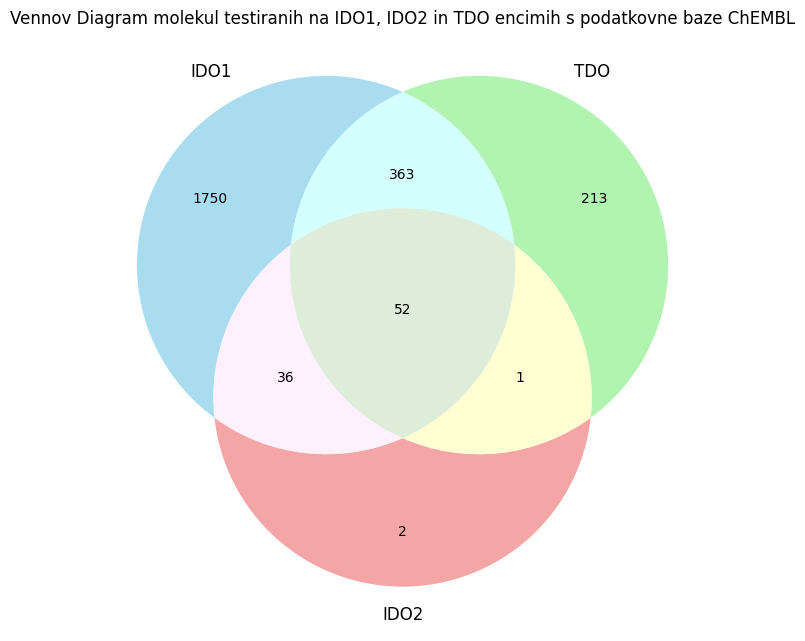

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted

# Assuming your DataFrame is already loaded, and it contains 'enzyme_name', 'target_organism', and 'monomer_id' columns.
# Example: bioactivities_df = pd.read_csv('your_data.csv')

# Enzyme names we're interested in
enzyme_names = ['Indoleamine 2,3-dioxygenase 1', 'Tryptophan 2,3-dioxygenase', 'Indoleamine 2,3-dioxygenase 2']

# Get sets of monomer_ids associated with each enzyme name
enzyme_set1 = set(bioactivities_df[bioactivities_df['target_chembl_id'].isin(['CHEMBL4685', 'CHEMBL1075294'])]['molecule_chembl_id'])
enzyme_set2 = set(bioactivities_df[bioactivities_df['target_chembl_id'].isin(['CHEMBL2140', 'CHEMBL1075307'])]['molecule_chembl_id'])
enzyme_set3 = set(bioactivities_df[bioactivities_df['target_chembl_id'].isin(['CHEMBL3627587', 'CHEMBL2189159'])]['molecule_chembl_id'])

# IDO1 CHEMBL4685 , CHEMBL1075294
# IDO2 CHEMBL2189159 , CHEMBL3627587
# TDO CHEMBL2140 , CHEMBL1075307


# Create the Venn diagram for monomer_id distributions over enzymes
plt.figure(figsize=(8, 8))
venn = venn3_unweighted(
    subsets=(enzyme_set1, enzyme_set2, enzyme_set3),
    set_labels=("IDO1", "TDO", "IDO2"),  # Enzyme names as labels
    set_colors=("skyblue", "lightgreen", "lightcoral"), alpha=0.7
)

# Set the title
plt.title("Vennov Diagram molekul testiranih na IDO1, IDO2 in TDO encimih s podatkovne baze ChEMBL")

# Show the plot
plt.show()

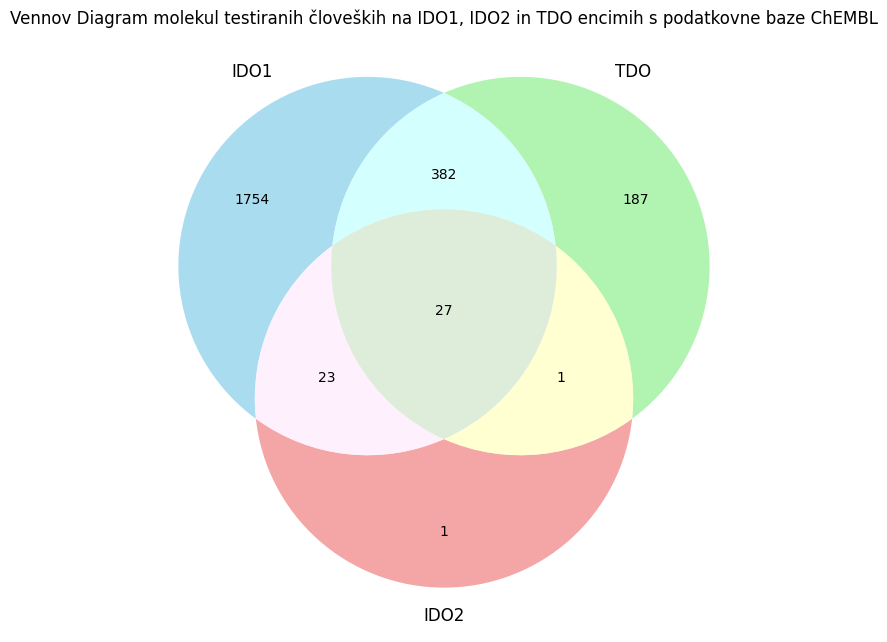

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted

# Assuming your DataFrame is already loaded with 'target_chembl_id', 'target_organism', and 'molecule_chembl_id' columns.
# Filter for Homo sapiens molecules only
human_molecules_chembl = bioactivities_df[bioactivities_df['target_organism'] == 'Homo sapiens']

# Enzyme names of interest based on ChEMBL IDs
enzyme_set1 = set(human_molecules_chembl[human_molecules_chembl['target_chembl_id'] == 'CHEMBL4685']['molecule_chembl_id'])
enzyme_set2 = set(human_molecules_chembl[human_molecules_chembl['target_chembl_id']== 'CHEMBL2140']['molecule_chembl_id'])
enzyme_set3 = set(human_molecules_chembl[human_molecules_chembl['target_chembl_id'] =='CHEMBL3627587']['molecule_chembl_id'])

# Create the Venn diagram for molecule_chembl_id distributions over enzymes
plt.figure(figsize=(8, 8))
venn3_unweighted(
    subsets=(enzyme_set1, enzyme_set2, enzyme_set3),
    set_labels=("IDO1", "TDO", "IDO2"),
    set_colors=("skyblue", "lightgreen", "lightcoral"),
    alpha=0.7
)

# Set the title
plt.title("Vennov Diagram molekul testiranih človeških na IDO1, IDO2 in TDO encimih s podatkovne baze ChEMBL")

# Show the plot
plt.show()

Glede na to da je večina molekul obeh podatkovnih baz testiranih na človeškem IDO1, in je IDO1 encim ki ga želimo zavirati bomon v nadaljnih analizah uporabljali le podatke molekul testiranih s človeškim IDO1